In [291]:
import numpy as np
import pandas as pd
import math

In [292]:
dtype_dict = {'name': str, 'review': str, 'rating': int}

In [293]:
products = pd.read_csv('amazon_baby.csv', dtype=dtype_dict)

In [294]:
products.columns

Index(['name', 'review', 'rating'], dtype='object')

In [295]:
products.dtypes

name      object
review    object
rating     int64
dtype: object

In [296]:
import string

punc_map = {}
for c in string.punctuation:
    punc_map[c] = ''
punc_trans = str.maketrans(punc_map)
print (punc_trans)

def remove_punctuation(text):
    return str.translate(text, punc_trans)
    
    

{33: '', 34: '', 35: '', 36: '', 37: '', 38: '', 39: '', 40: '', 41: '', 42: '', 43: '', 44: '', 45: '', 46: '', 47: '', 58: '', 59: '', 60: '', 61: '', 62: '', 63: '', 64: '', 91: '', 92: '', 93: '', 94: '', 95: '', 96: '', 123: '', 124: '', 125: '', 126: ''}


In [297]:
remove_punctuation("A hihi... !!! hello")

'A hihi  hello'

In [298]:
products['review'].values

array(['These flannel wipes are OK, but in my opinion not worth keeping.  I also ordered someImse Vimse Cloth Wipes-Ocean Blue-12 countwhich are larger, had a nicer, softer texture and just seemed higher quality.  I use cloth wipes for hands and faces and have been usingThirsties 6 Pack Fab Wipes, Boyfor about 8 months now and need to replace them because they are starting to get rough and have had stink issues for a while that stripping no longer handles.',
       'it came early and was not disappointed. i love planet wise bags and now my wipe holder. it keps my osocozy wipes moist and does not leak. highly recommend it.',
       'Very soft and comfortable and warmer than it looks...fit the full size bed perfectly...would recommend to anyone looking for this type of quilt',
       ...,
       'This item looks great and cool for my kids....I know this Company and its great in quality...',
       'I am extremely happy with this product. I have been searching for a product like this for 

In [299]:
products.fillna('', inplace=True)

In [300]:
products['review_clean'] = products['review'].apply(remove_punctuation)

## Extract sentiments

In [301]:
products = products[products['rating'] != 3]

In [302]:
products['sentiment'] = products['rating'].apply(lambda rating: 1 if rating > 3 else -1)

## Splitting into training and test sets

In [303]:
train_idx = pd.read_json('module-9-assignment-train-idx.json')[0]
test_idx = pd.read_json('module-9-assignment-test-idx.json')[0]

In [304]:
train_data = products.iloc[train_idx]
test_data = products.iloc[test_idx]

## Build the word count vector for each review


In [305]:
from sklearn.feature_extraction.text import CountVectorizer

In [306]:
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
train_matrix = vectorizer.fit_transform(train_data['review_clean'])

In [307]:
test_matrix = vectorizer.transform(test_data['review_clean'])

## Train a sentiment classifier with logistic regression


In [308]:
from sklearn.linear_model import LogisticRegression

In [309]:
lr = LogisticRegression()

In [310]:
lr.fit(train_matrix, train_data['sentiment'])

/Users/tdx/anaconda2/envs/ds-env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tdx/anaconda2/envs/ds-env/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [311]:
len(lr.coef_)

1

In [312]:
LogisticRegression

sklearn.linear_model.logistic.LogisticRegression

In [313]:
from sklearn.metrics import accuracy_score

In [314]:
accuracy = accuracy_score(y_true=test_data['sentiment'],
                          y_pred=lr.predict(test_matrix)
                         )
print ("Test accuracy: %.2f" % accuracy)

Test accuracy: 0.93


### Baseline: Majority class prediction


In [315]:
baseline = len(test_data[test_data['sentiment'] == 1]) / len(test_data)
print ("Baseline accuracy (majority class classifier): %s" % baseline)

Baseline accuracy (majority class classifier): 0.8427825773938085


### Quiz question: Using accuracy as the evaluation metric, was our logistic regression model better than the baseline (majority class classifier)?



In [316]:
accuracy > baseline

True

## Confusion matrix

In [317]:
from sklearn.metrics import confusion_matrix

cmat = confusion_matrix(y_true=test_data['sentiment'],
                        y_pred=lr.predict(test_matrix),
                        labels=lr.classes_
                       )

print (' target_label | predicted_label | count')
print ('--------------|-----------------|-----------')

for i, target_label in enumerate(lr.classes_):
    for j, predicted_label in enumerate(lr.classes_):
        print ('{0:^13} | {1:^15} | {2:5d}'.format(target_label, predicted_label, cmat[i,j]))

 target_label | predicted_label | count
--------------|-----------------|-----------
     -1       |       -1        |  3790
     -1       |        1        |  1451
      1       |       -1        |   803
      1       |        1        | 27292


### Quiz Question: How many predicted values in the test set are false positives?

In [318]:
cmat[0,1]

1451

In [319]:
# 1454 (as in the reading)

In [360]:
(test_data['sentiment']==-1).sum() / len(test_data)

0.1572174226061915

### Computing the cost of mistakes

In [320]:
false_positive = 1454
false_negative = 805
total_cost = 100 * false_positive + 1 * false_negative
print ("Total cost: %s" % total_cost)

Total cost: 146205


## Precision and recall

In [321]:
from sklearn.metrics import precision_score

precision = precision_score(y_true=test_data['sentiment'],
                            y_pred=lr.predict(test_matrix)
                           )
print ("Precision on test data: %.2f" % precision)

Precision on test data: 0.95


## Quiz Question: Out of all reviews in the test set that are predicted to be positive, what fraction of them are false positives? (Round to the second decimal place e.g. 0.25)



In [322]:
print ("False positive: %.2f" % (1 - precision))

False positive: 0.05


### Quiz Question: Based on what we learned in lecture, if we wanted to reduce this fraction of false positives to be below 3.5%, we would: (see quiz)



>????


In [323]:
from sklearn.metrics import recall_score

recall = recall_score(y_true=test_data['sentiment'],
                      y_pred=lr.predict(test_matrix)
                     )
print ("Recall on test data: %.2f" % recall)

Recall on test data: 0.97


### Quiz Question: What fraction of the positive reviews in the test_set were correctly predicted as positive by the classifier?



In [324]:
recall

0.9714184018508631

### Quiz Question: What is the recall value for a classifier that predicts +1 for all data points in the test_data?


### 1.0

## Precision-recall tradeoff


## Varying the threshold

In [325]:
def apply_threshold(probabilities, threshold):
    return [+1 if u>=threshold else -1 for u in probabilities]

In [326]:
probabilities = lr.predict_proba(test_matrix)[:,1]

In [327]:
threshold_0_5_prediction = np.array(apply_threshold(probabilities, 0.5))

In [328]:
threshold_0_9_prediction = np.array(apply_threshold(probabilities, 0.9))

In [329]:
test_matrix.shape[0]

33336

In [330]:
(threshold_0_5_prediction == 1).sum()

28743

In [331]:
(threshold_0_9_prediction == 1).sum()

25068

### Quiz question: What happens to the number of positive predicted reviews as the threshold increased from 0.5 to 0.9?


In [332]:
(threshold_0_9_prediction == 1).sum() < (threshold_0_5_prediction == 1).sum()

True

#### Decrease

### Exploring the associated precision and recall as the threshold varies


In [333]:
precision

0.9495181435479942

In [334]:
recall

0.9714184018508631

In [335]:
precision_0_5 = precision_score(y_true=test_data['sentiment'],
                            y_pred=threshold_0_5_prediction
                           )
recall_0_5 = recall_score(y_true=test_data['sentiment'],
                          y_pred=threshold_0_5_prediction
                         )
print ("Precision, recall : %s, %s" % (precision_0_5, recall_0_5))

Precision, recall : 0.9495181435479942, 0.9714184018508631


In [336]:
precision_0_9 = precision_score(y_true=test_data['sentiment'],
                            y_pred=threshold_0_9_prediction
                           )
recall_0_9 = recall_score(y_true=test_data['sentiment'],
                          y_pred=threshold_0_9_prediction
                         )
print ("Precision, recall : %s, %s" % (precision_0_9, recall_0_9))

Precision, recall : 0.9816499122387107, 0.8758853888592276


### Quiz Question (variant 1): Does the precision increase with a higher threshold?

In [337]:
precision_0_9 > precision_0_5

True

### Quiz Question (variant 2): Does the recall increase with a higher threshold?



In [338]:
recall_0_9 > recall_0_5

False

### Precision-recall curve


In [339]:
threshold_values = np.linspace(0.5, 1, num=100)
print (threshold_values)

[0.5        0.50505051 0.51010101 0.51515152 0.52020202 0.52525253
 0.53030303 0.53535354 0.54040404 0.54545455 0.55050505 0.55555556
 0.56060606 0.56565657 0.57070707 0.57575758 0.58080808 0.58585859
 0.59090909 0.5959596  0.6010101  0.60606061 0.61111111 0.61616162
 0.62121212 0.62626263 0.63131313 0.63636364 0.64141414 0.64646465
 0.65151515 0.65656566 0.66161616 0.66666667 0.67171717 0.67676768
 0.68181818 0.68686869 0.69191919 0.6969697  0.7020202  0.70707071
 0.71212121 0.71717172 0.72222222 0.72727273 0.73232323 0.73737374
 0.74242424 0.74747475 0.75252525 0.75757576 0.76262626 0.76767677
 0.77272727 0.77777778 0.78282828 0.78787879 0.79292929 0.7979798
 0.8030303  0.80808081 0.81313131 0.81818182 0.82323232 0.82828283
 0.83333333 0.83838384 0.84343434 0.84848485 0.85353535 0.85858586
 0.86363636 0.86868687 0.87373737 0.87878788 0.88383838 0.88888889
 0.89393939 0.8989899  0.9040404  0.90909091 0.91414141 0.91919192
 0.92424242 0.92929293 0.93434343 0.93939394 0.94444444 0.94949

In [340]:
precision_all = []
recall_all = []

for threshold_value in threshold_values:
    cur_threshold_prediction = np.array(apply_threshold(probabilities, threshold_value))
    cur_precision = precision_score(y_true=test_data['sentiment'],
                            y_pred=cur_threshold_prediction)
    cur_recall = recall_score(y_true=test_data['sentiment'],
                          y_pred=cur_threshold_prediction)
    precision_all += [cur_precision]
    recall_all += [cur_recall]
    

In [341]:
from matplotlib import pyplot as plt

In [342]:
def plot_pr_curve(precision, recall, title):
    plt.rcParams['figure.figsize'] = 7, 5
    plt.locator_params(axis = 'x', nbins = 5)
    plt.plot(precision, recall, 'b-', linewidth=4.0, color = '#B0017F')
    plt.title(title)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.rcParams.update({'font.size': 16})

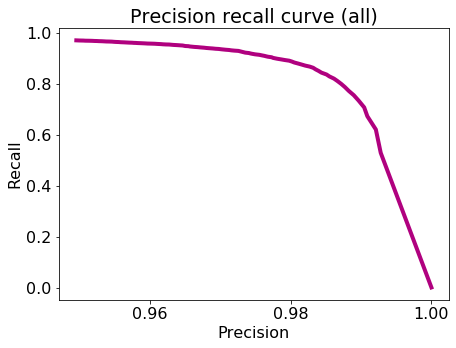

In [343]:
plot_pr_curve(precision_all, recall_all, 'Precision recall curve (all)')

### Quiz Question: Among all the threshold values tried, what is the smallest threshold value that achieves a precision of 96.5% or better? Round your answer to 3 decimal places.



In [344]:
np_precision_all = np.array(precision_all)


for i in range(len(threshold_values)):
    if (precision_all[i] >= 0.965):
        print (threshold_values[i], precision_all[i], recall_all[i])
        break

0.7070707070707071 0.9650068755880438 0.9491724506139883


### Quiz Question: Using threshold = 0.98, how many false negatives do we get on the test_data? This is the number of false negatives (i.e the number of reviews to look at when not needed) that we have to deal with using this classifier.

In [345]:
cmat = confusion_matrix(y_true=test_data['sentiment'],
                        y_pred=apply_threshold(probabilities, 0.98),
                        labels=lr.classes_
                       )

In [346]:
print (' target_label | predicted_label | count')
print ('--------------|-----------------|-----------')

for i, target_label in enumerate(lr.classes_):
    for j, predicted_label in enumerate(lr.classes_):
        print ('{0:^13} | {1:^15} | {2:5d}'.format(target_label, predicted_label, cmat[i,j]))

 target_label | predicted_label | count
--------------|-----------------|-----------
     -1       |       -1        |  5049
     -1       |        1        |   192
      1       |       -1        |  8230
      1       |        1        | 19865


In [347]:
print ("False negative with threshold=0.98 is: %s" % cmat[1, 0])

False negative with threshold=0.98 is: 8230


### Evaluating specific search terms


### Precision-Recall on all baby related items


In [348]:
baby_reviews = test_data[test_data['name'].apply(lambda u: 'baby' in u.lower())]

In [349]:
baby_reviews

,name,review,rating,review_clean,sentiment
9,"Baby Tracker&reg; - Daily Childcare Journal, S...",This has been an easy way for my nanny to reco...,4,This has been an easy way for my nanny to reco...,1
10,"Baby Tracker&reg; - Daily Childcare Journal, S...",I love this journal and our nanny uses it ever...,4,I love this journal and our nanny uses it ever...,1
56,Baby's First Year Undated Wall Calendar with S...,I searched high and low for a first year calen...,5,I searched high and low for a first year calen...,1
59,Our Baby Girl Memory Book,Absolutely love it and all of the Scripture in...,5,Absolutely love it and all of the Scripture in...,1
112,Newborn Baby Tracker&reg; - Round the Clock Ch...,This is the best way to keep track of when you...,5,This is the best way to keep track of when you...,1
115,"Large Jungle Animals (Panda, Lion, Elephant, G...",I ordered these for my 7 month old sons play a...,5,I ordered these for my 7 month old sons play a...,1
192,Sassy Who Loves Baby? Photo Album Book with te...,I bought this for a new granddaughter. I will...,5,I bought this for a new granddaughter I will ...,1
193,Sassy Who Loves Baby? Photo Album Book with te...,I originally bought this for my 4 month old so...,5,I originally bought this for my 4 month old so...,1
279,Crown Crafts The Original NoJo BabySling by Dr...,This is a great product but it is just too big...,1,This is a great product but it is just too big...,-1
281,Crown Crafts The Original NoJo BabySling by Dr...,"I used this sling for both of my babies, (0-&g...",5,I used this sling for both of my babies 0gt 25...,1


In [350]:
baby_matrix = vectorizer.transform(baby_reviews['review_clean'])
probabilities = lr.predict_proba(baby_matrix)[:,1]

In [351]:
baby_reviews

,name,review,rating,review_clean,sentiment
9,"Baby Tracker&reg; - Daily Childcare Journal, S...",This has been an easy way for my nanny to reco...,4,This has been an easy way for my nanny to reco...,1
10,"Baby Tracker&reg; - Daily Childcare Journal, S...",I love this journal and our nanny uses it ever...,4,I love this journal and our nanny uses it ever...,1
56,Baby's First Year Undated Wall Calendar with S...,I searched high and low for a first year calen...,5,I searched high and low for a first year calen...,1
59,Our Baby Girl Memory Book,Absolutely love it and all of the Scripture in...,5,Absolutely love it and all of the Scripture in...,1
112,Newborn Baby Tracker&reg; - Round the Clock Ch...,This is the best way to keep track of when you...,5,This is the best way to keep track of when you...,1
115,"Large Jungle Animals (Panda, Lion, Elephant, G...",I ordered these for my 7 month old sons play a...,5,I ordered these for my 7 month old sons play a...,1
192,Sassy Who Loves Baby? Photo Album Book with te...,I bought this for a new granddaughter. I will...,5,I bought this for a new granddaughter I will ...,1
193,Sassy Who Loves Baby? Photo Album Book with te...,I originally bought this for my 4 month old so...,5,I originally bought this for my 4 month old so...,1
279,Crown Crafts The Original NoJo BabySling by Dr...,This is a great product but it is just too big...,1,This is a great product but it is just too big...,-1
281,Crown Crafts The Original NoJo BabySling by Dr...,"I used this sling for both of my babies, (0-&g...",5,I used this sling for both of my babies 0gt 25...,1


In [352]:
threshold_values = np.linspace(0.5, 1, num=100)

In [353]:
precision_all = []
recall_all = []

for threshold_value in threshold_values:
    cur_threshold_prediction = np.array(apply_threshold(probabilities, threshold_value))
    cur_precision = precision_score(y_true=baby_reviews['sentiment'],
                            y_pred=cur_threshold_prediction)
    cur_recall = recall_score(y_true=baby_reviews['sentiment'],
                          y_pred=cur_threshold_prediction)
    precision_all += [cur_precision]
    recall_all += [cur_recall]
    

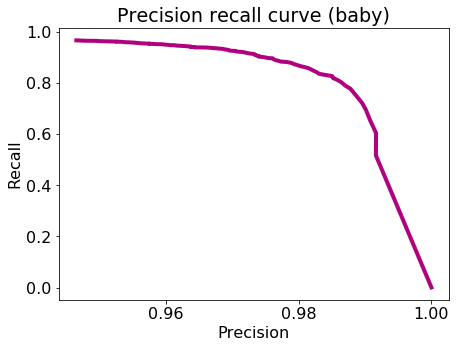

In [354]:
plot_pr_curve(precision_all, recall_all, 'Precision recall curve (baby)')

### Quiz Question: Among all the threshold values tried, what is the smallest threshold value that achieves a precision of 96.5% or better for the reviews of data in baby_reviews? Round your answer to 3 decimal places.


In [355]:
np_precision_all = np.array(precision_all)

for i in range(len(threshold_values)):
    if (precision_all[i] >= 0.965):
        print (threshold_values[i], precision_all[i], recall_all[i])
        break

0.7272727272727273 0.9652790741086429 0.9400109071077986
